# Configurations

### Import

In [1]:
import os
import copy
import joblib
from IPython.display import clear_output
from tqdm import tqdm

import holidays
import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import torch
import pytorch_model_summary
import torch.nn.functional as F
from transformers import ViTModel, ViTImageProcessor, ViTConfig, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
import timm
from torchvision import transforms
from PIL import Image
import cv2
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Params

In [2]:
# Data params
encoder_len = 11
pred_len = 1
# batch_size = 10
batch_size = 128

# Model hyperparameter
d_model = 128; d_model = 256; d_model = 512
nhead = 4; nhead = 8
d_ff = 512; d_ff = 2048
dropout = 0.3; # dropout = 0.1
num_layers = 4; num_layers = 6

# Data

### Read

In [3]:
df_train = pd.read_csv("../visuelle/train.csv", parse_dates=["release_date"])
df_test = pd.read_csv("../visuelle/test.csv", parse_dates=["release_date"])
df_trans = pd.concat([df_train, df_test]).rename(columns={"image_path":"img_path"})
df_trans[[str(i) for i in range(0, 12)]] = df_trans[[str(i) for i in range(0, 12)]] * np.load("../visuelle/normalization_scale.npy")
df_trans.head()

,0,1,2,3,4,5,6,7,8,9,10,11,external_code,season,category,release_date,day,week,month,year,img_path,color,fabric,extra
0,5.0,78.0,66.0,71.0,49.0,46.0,28.0,21.0,13.0,15.0,11.0,10.0,1,SS17,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00001.png,yellow,acrylic,hem
1,6.0,117.0,137.0,144.0,88.0,105.0,68.0,56.0,37.0,148.0,170.0,59.0,2,SS17,long sleeve,2016-12-01,0.500000,0.923077,1.0,0.998514,PE17/00002.png,brown,acrylic,hem
2,3.0,221.0,189.0,102.0,44.0,32.0,16.0,7.0,11.0,6.0,3.0,2.0,3,SS17,culottes,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00003.png,blue,scuba crepe,hem
3,1.0,47.0,50.0,44.0,30.0,34.0,34.0,25.0,18.0,30.0,22.0,10.0,4,SS17,long sleeve,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00004.png,yellow,acrylic,sleeveless
4,7.0,105.0,134.0,128.0,73.0,50.0,46.0,37.0,32.0,31.0,36.0,10.0,5,SS17,long sleeve,2016-12-02,0.666667,0.923077,1.0,0.998514,PE17/00005.png,grey,acrylic,hem


### Preprocess

In [4]:
def preprocess(data, encoder_len, pred_len, is_train=True):
    data = data.copy()

    # Melt data
    data = data.melt(
            id_vars=["img_path", "season", "category", "release_date", "color", "fabric", "extra"],
            value_vars=[str(i) for i in range(12)], value_name="sales",
            var_name="time_idx"
                )
    data["sales"] = data["sales"].apply(lambda x: x if x>0 else 0)
    data["time_idx"] = data["time_idx"].astype(int)
    data = data.sort_values(["img_path", "time_idx"]).reset_index(drop=True)

   # Img_path
    data["img_path"] = data["img_path"].apply(lambda x: f'../visuelle/images/{x}')

   # Temporal informations
    data["year"] = data["release_date"].dt.year
    data["month"] = data["release_date"].dt.month
    data["week"] = data["release_date"].dt.isocalendar().week
    data["dayofweek"] = data["release_date"].dt.dayofweek
    data["day"] = data["release_date"].dt.day

    # Calibrate week
    data.loc[(data["month"] == 12) & (data["week"] < 10), "week"] = 53
    data.loc[(data["month"] == 1) & (data["week"] > 10), "week"] = 1

    # Cyclic transformation
    def append_cyclic(col, cycle):
        data[f"{col}_sin"] = np.sin(2 * np.pi * data[col]/cycle)
        data[f"{col}_cos"] = np.cos(2 * np.pi * data[col]/cycle)
    
    append_cyclic("month", 12)
    append_cyclic("week", 53)
    append_cyclic("dayofweek", 7)
    append_cyclic("day", 365)
   
    seq_col_li = ["year", "month", "month_cos", "week_sin", "week_cos", "dayofweek_sin", "dayofweek_cos", "day_sin", "day_cos"]
    cat_col_li = ["season", "category", "color", "fabric", "extra"]
   
   # Aggregate to list
    data = data.groupby(["img_path"] + cat_col_li, as_index=False)\
                        [["sales"] + seq_col_li].agg(list)

   # Filter
    data["size"] = data["sales"].str.len()
    if is_train: data = data[data["size"] >= encoder_len + pred_len]
    else: data = data[data["size"] >= pred_len + 1]

    return data.reset_index(drop=True), seq_col_li, cat_col_li

df_prep, seq_col_li, cat_col_li = preprocess(df_trans, encoder_len, pred_len)

# Save
df_prep.to_parquet("df_prep_visuelle.parquet")
joblib.dump(seq_col_li, "seq_col_li_visuelle.pkl")
joblib.dump(cat_col_li, "cat_col_li_visuelle.pkl")

['cat_col_li_visuelle.pkl']

### Dataset

In [3]:
# Reference
df_prep = pd.read_parquet("df_prep_visuelle.parquet")
seq_col_li = joblib.load("seq_col_li_visuelle.pkl")
seq_col_li.remove("year")
cat_col_li = joblib.load("cat_col_li_visuelle.pkl")

class Dataset(torch.utils.data.DataLoader):
    def __init__(self, data, seq_col_li, cat_col_li, encoder_len, pred_len):
        self.sales_li, self.temporal_li, self.static_li, self.img_li = [], [], [], []
        for _, row in tqdm(data.iterrows()):
            # Sales and temporal
            sales_temporal = np.array([i.astype(float) for i in row[["sales"] + seq_col_li].values]).T
            sales_temporal = torch.FloatTensor(sales_temporal).unfold(0, encoder_len+pred_len, 1).permute(0,2,1)
            sales = sales_temporal[:, :, 0].numpy()
            temporal = sales_temporal[:, :, 1:].numpy()
            
            # Static and image
            static_img = row[cat_col_li + ["img_path"]].values[None, ...]
            static_img = np.repeat(static_img, temporal.shape[0], 0)
            
            static = static_img[:, :len(cat_col_li)]
            static_label = static_img[:, len(cat_col_li):-1]
            img = static_img[:, -1]

            self.sales_li.append(sales)
            self.temporal_li.append(temporal)
            self.static_li.append(static)
            self.img_li.append(img)
        
        self.sales_li = np.concatenate(self.sales_li)
        self.temporal_li = np.concatenate(self.temporal_li)
        self.static_li.append(static)
        self.img_li = np.concatenate(self.img_li)

        self.transform = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
        
    def __len__(self):
        return len(self.sales_li)
    
    def __getitem__(self, idx):
        hist = np.log1p(self.sales_li[idx][:-pred_len][..., None])
        y = np.log1p(self.sales_li[idx][-pred_len:][..., None])
        
        temporal = self.temporal_li[idx]
        static = self.static_li[idx]
        
        img = Image.open(self.img_li[idx]).convert("RGB")
        img_raw = img
        img_tensor = self.transform(img, return_tensors="np")["pixel_values"].squeeze()

        return hist, temporal, static, img_raw, img_tensor, y

def func(data, tokenizer):
    hist = np.array([hist for hist, temporal, static, img_raw, img_tensor, y in data])
    temporal = np.array([temporal for hist, temporal, static, img_raw, img_tensor, y in data])
    static = np.array([static for hist, temporal, static, img_raw, img_tensor, y in data])
    static = static.flatten()
    static = static.tolist()
    static = tokenizer(static, return_tensors="pt", padding=True, add_special_tokens=True)

    img_raw = [img_raw for hist, temporal, static, img_raw, img_tensor, y in data]
    img_tensor = np.array([img_tensor for hist, temporal, static, img_raw, img_tensor, y in data])
    y = np.array([y for hist, temporal, static, img_raw, img_tensor, y in data])

    return torch.FloatTensor(hist), torch.FloatTensor(temporal), static, img_raw, torch.FloatTensor(img_tensor), torch.FloatTensor(y)

dataset = Dataset(df_prep, seq_col_li, cat_col_li, encoder_len, pred_len)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: func(x, tokenizer), num_workers=4, prefetch_factor=4, drop_last=True) # num_workers=8, prefetch_factor=8
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: func(x, tokenizer))
for data in dataloader:
    hist, temporal, static, img_raw, img_tensor, y = data
    print("hist:", hist.shape)
    print("temporal:", temporal.shape)
    # print("static:", static.shape)
    # print("img_raw:", img_raw.shape)
    print("img_tensor:", img_tensor.shape)
    print("_"*100)
    print("y:", y.shape)
    break

0it [00:00, ?it/s]

5577it [00:01, 3140.59it/s]


hist: torch.Size([128, 11, 1])
temporal: torch.Size([128, 12, 8])
img_tensor: torch.Size([128, 3, 224, 224])
____________________________________________________________________________________________________
y: torch.Size([128, 1, 1])


# Architecture

In [8]:
def get_img_mask(arr):
    res = torch.where(arr==-1, -torch.inf, 0)
    return res

def get_padding_mask(arr):
    res = torch.where(arr==0, -torch.inf, 0)
    return res

def _get_seq_len(src, batch_first):
    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

def _detect_is_causal_mask(mask, is_causal=None, size=None):
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal

class FeedForwardEmbedder(torch.nn.Module):
    def __init__(self, input_dim, d_model, d_ff, dropout):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_dim, d_ff)
        self.activation = torch.nn.GELU()
        self.dropout = torch.nn.Dropout(dropout)
        self.linear2 = torch.nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

class CustomEncoderLayer(torch.nn.TransformerEncoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation, batch_first):
        super().__init__(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, batch_first=batch_first)
    
    def forward(self, src, positional_embedding, src_mask=None, src_key_padding_mask=None, is_causal=False):
       #################################################################################################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(src_mask),
            other_name="src_mask",
            target_type=src.dtype)

        src_mask = F._canonical_mask(
            mask=src_mask,
            mask_name="src_mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,)

        # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf
        why_not_sparsity_fast_path = ''
        if not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif self.training:
            why_not_sparsity_fast_path = "training is enabled"
        elif not self.self_attn.batch_first :
            why_not_sparsity_fast_path = "self_attn.batch_first was not True"
        elif not self.self_attn._qkv_same_embed_dim :
            why_not_sparsity_fast_path = "self_attn._qkv_same_embed_dim was not True"
        elif not self.activation_relu_or_gelu:
            why_not_sparsity_fast_path = "activation_relu_or_gelu was not True"
        elif not (self.norm1.eps == self.norm2.eps):
            why_not_sparsity_fast_path = "norm1.eps is not equal to norm2.eps"
        elif src.is_nested and (src_key_padding_mask is not None or src_mask is not None):
            why_not_sparsity_fast_path = "neither src_key_padding_mask nor src_mask are not supported with NestedTensor input"
        elif self.self_attn.num_heads % 2 == 1:
            why_not_sparsity_fast_path = "num_head is odd"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"
        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                self.self_attn.in_proj_weight,
                self.self_attn.in_proj_bias,
                self.self_attn.out_proj.weight,
                self.self_attn.out_proj.bias,
                self.norm1.weight,
                self.norm1.bias,
                self.norm2.weight,
                self.norm2.bias,
                self.linear1.weight,
                self.linear1.bias,
                self.linear2.weight,
                self.linear2.bias,
            )

            # We have to use list comprehensions below because TorchScript does not support
            # generator expressions.
            _supported_device_type = ["cpu", "cuda"]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif not all((x.device.type in _supported_device_type) for x in tensor_args):
                why_not_sparsity_fast_path = ("some Tensor argument's device is neither one of "
                                              f"{_supported_device_type}")
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if not why_not_sparsity_fast_path:
                merged_mask, mask_type = self.self_attn.merge_masks(src_mask, src_key_padding_mask, src)
                return torch._transformer_encoder_layer_fwd(
                    src,
                    self.self_attn.embed_dim,
                    self.self_attn.num_heads,
                    self.self_attn.in_proj_weight,
                    self.self_attn.in_proj_bias,
                    self.self_attn.out_proj.weight,
                    self.self_attn.out_proj.bias,
                    self.activation_relu_or_gelu == 2,
                    self.norm_first,
                    self.norm1.eps,
                    self.norm1.weight,
                    self.norm1.bias,
                    self.norm2.weight,
                    self.norm2.bias,
                    self.linear1.weight,
                    self.linear1.bias,
                    self.linear2.weight,
                    self.linear2.bias,
                    merged_mask,
                    mask_type,
                )
       #################################################################################################################################################
        query = src + positional_embedding
        key = src + positional_embedding
        value = src
        if self.norm_first:
            print("norm_first not suppoted")
            raise
        else:
            x = self.norm1(src + self._sa_block(query, key, value, src_mask, src_key_padding_mask, is_causal=is_causal))
            x = self.norm2(x + self._ff_block(x))

        return x
    
    def _sa_block(self, query, key, value, attn_mask, key_padding_mask, is_causal=False):
            x = self.self_attn(query, key, value,
                            attn_mask=attn_mask,
                            key_padding_mask=key_padding_mask,
                            need_weights=False, is_causal=is_causal)[0]
            
            return self.dropout1(x)

class CustomEncoder(torch.nn.TransformerEncoder):
    def __init__(self, encoder_layer, num_layers):
        super().__init__(encoder_layer=encoder_layer, num_layers=num_layers)
    
    def forward(self, src, positional_embedding, mask=None, src_key_padding_mask=None, is_causal=None):
       ##########################################################################
        src_key_padding_mask = F._canonical_mask(
            mask=src_key_padding_mask,
            mask_name="src_key_padding_mask",
            other_type=F._none_or_dtype(mask),
            other_name="mask",
            target_type=src.dtype
        )

        mask = F._canonical_mask(
            mask=mask,
            mask_name="mask",
            other_type=None,
            other_name="",
            target_type=src.dtype,
            check_other=False,
        )

        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        src_key_padding_mask_for_layers = src_key_padding_mask
        why_not_sparsity_fast_path = ''
        str_first_layer = "self.layers[0]"
        batch_first = first_layer.self_attn.batch_first
        if not hasattr(self, "use_nested_tensor"):
            why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
        elif not self.use_nested_tensor:
            why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
        elif first_layer.training:
            why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
        elif not src.dim() == 3:
            why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
        elif src_key_padding_mask is None:
            why_not_sparsity_fast_path = "src_key_padding_mask was None"
        elif (((not hasattr(self, "mask_check")) or self.mask_check)
                and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
            why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
        elif output.is_nested:
            why_not_sparsity_fast_path = "NestedTensor input is not supported"
        elif mask is not None:
            why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
        elif torch.is_autocast_enabled():
            why_not_sparsity_fast_path = "autocast is enabled"

        if not why_not_sparsity_fast_path:
            tensor_args = (
                src,
                first_layer.self_attn.in_proj_weight,
                first_layer.self_attn.in_proj_bias,
                first_layer.self_attn.out_proj.weight,
                first_layer.self_attn.out_proj.bias,
                first_layer.norm1.weight,
                first_layer.norm1.bias,
                first_layer.norm2.weight,
                first_layer.norm2.bias,
                first_layer.linear1.weight,
                first_layer.linear1.bias,
                first_layer.linear2.weight,
                first_layer.linear2.bias,
            )
            _supported_device_type = ["cpu", "cuda"]
            if torch.overrides.has_torch_function(tensor_args):
                why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
            elif src.device.type not in _supported_device_type:
                why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
            elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
                why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
                                              "input/output projection weights or biases requires_grad")

            if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
                convert_to_nested = True
                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
                src_key_padding_mask_for_layers = None

        seq_len = _get_seq_len(src, batch_first)
        is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
       ##########################################################################
        for mod in self.layers:
            output = mod(output, positional_embedding, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

        if convert_to_nested:
            output = output.to_padded_tensor(0., src.size())

        if self.norm is not None:
            output = self.norm(output)

        return output

class DecoderLayer(torch.nn.TransformerDecoderLayer):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation, batch_first):
        super().__init__(d_model, nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, batch_first=batch_first)
        self.multihead_attn1 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.multihead_attn2 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.multihead_attn3 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.norm4 = torch.nn.LayerNorm(d_model)
        self.norm5 = torch.nn.LayerNorm(d_model)
    
    def forward(self, tgt, memory1, memory2, memory3, decoder_positional_embedding, hist_positional_embedding, img_positional_embedding, hist_key_padding_mask, img_key_padding_mask, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=False, memory_is_causal=False):
        if self.norm_first:
            print("norm_first not supported")
            raise
        else:
            # Self attention
            query = tgt + decoder_positional_embedding
            key = tgt + decoder_positional_embedding
            value = tgt
            x = self.norm1(tgt + self._sa_block(query, key, value, tgt_mask, tgt_key_padding_mask, tgt_is_causal))

            # Hist cross attnetion
            attn_weight1 = None
            query = x + decoder_positional_embedding
            key = memory1 + hist_positional_embedding
            value = memory1
            mha_output, attn_weight1 = self._mha_block(self.multihead_attn1, query, key, value, memory_mask, hist_key_padding_mask, memory_is_causal)
            x = self.norm2(x + mha_output)

            # Static cross attention
            attn_weight2 = None
            query = x + decoder_positional_embedding
            key = memory2
            value = memory2
            mha_output, attn_weight2 = self._mha_block(self.multihead_attn2, query, key, value, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = self.norm3(x + mha_output)

            # Image cross attention
            query = x + decoder_positional_embedding
            key = memory3 + img_positional_embedding
            value = memory3
            mha_output, attn_weight3 = self._mha_block(self.multihead_attn3, query, key, value, memory_mask, img_key_padding_mask, memory_is_causal)
            x = self.norm4(x + mha_output)

            # Feed forward
            x = self.norm5(x + self._ff_block(x))

        return x, attn_weight1, attn_weight2, attn_weight3

    # self-attention block
    def _sa_block(self, query, key, value, attn_mask, key_padding_mask, is_causal=False):
        x = self.self_attn(query, key, value,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           is_causal=is_causal,
                           need_weights=False)[0]
        return self.dropout1(x)

    # multihead attention block
    def _mha_block(self, block, query, key, value, attn_mask, key_padding_mask, is_causal=False):
        x, attn_weight = block(query, key, value,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                is_causal=is_causal,
                                need_weights=True, average_attn_weights=False)
        return self.dropout2(x), attn_weight

class Decoder(torch.nn.TransformerDecoder):
    def __init__(self, decoder_layer, num_layers):
        super().__init__(decoder_layer, num_layers)
    
    def forward(self, tgt, memory1, memory2, memory3, decoder_positional_embedding, hist_positional_embedding, img_positional_embedding, hist_key_padding_mask, img_key_padding_mask, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=None, memory_is_causal=False):
        output = tgt
        seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
        tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

        for mod in self.layers:
            output, attn_weight1, attn_weight2, attn_weight3 = mod(tgt, memory1, memory2, memory3, decoder_positional_embedding, hist_positional_embedding, img_positional_embedding,
                        tgt_mask=tgt_mask,
                        memory_mask=memory_mask,
                        tgt_key_padding_mask=tgt_key_padding_mask,
                        hist_key_padding_mask=hist_key_padding_mask, 
                        img_key_padding_mask=img_key_padding_mask,
                        memory_key_padding_mask=memory_key_padding_mask,
                        tgt_is_causal=tgt_is_causal,
                        memory_is_causal=memory_is_causal)

        if self.norm is not None:
            output = self.norm(output)

        return output, attn_weight1, attn_weight2, attn_weight3

class Transformer(torch.nn.Module):
    def __init__(self, seq_col_li, cat_col_li, encoder_len, pred_len, 
                d_model, nhead, num_layers, d_ff, dropout):
        super().__init__()
       
       # Positional embedding and mask
        self.temporal_embedder = FeedForwardEmbedder(len(seq_col_li), d_model, d_ff, dropout)

       # Hist enncoder
        self.hist_embedder = torch.nn.Linear(1, d_model)
        hist_encoder_layer = CustomEncoderLayer(d_model, nhead, dim_feedforward=d_ff, dropout=dropout, activation="gelu", batch_first=True)
        self.hist_encoder = CustomEncoder(hist_encoder_layer, num_layers=num_layers)

       # Static encoder
        self.static_embedder = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
        self.static_linear = torch.nn.Linear(768, d_model)

       # Image encoder
        self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
        # self.img_model = timm.create_model('vit_base_patch8_224.augreg2_in21k_ft_in1k', pretrained=True).to(device)
        self.img_linear = torch.nn.Linear(768, d_model)
        self.img_posemb_linear = torch.nn.Linear(768, d_model)

       # Decoder
        decoder_layer = DecoderLayer(d_model, nhead, dim_feedforward=d_ff, dropout=dropout, activation="gelu", batch_first=True)
        self.decoder = Decoder(decoder_layer, num_layers)

       # Final
        self.linear = torch.nn.Linear(d_model, 1)

    def forward(self, hist, temporal, static_input_ids, static_attention_mask, img, verbose=False):
       # Positional embedding
        temporal_embedding = self.temporal_embedder(temporal)
        hist_positional_embedding = temporal_embedding[:, :encoder_len, :]
        decoder_positional_embedding = temporal_embedding[:, -pred_len:, :]
    
       # Encoder
        # Hist encoder
        hist_enc_output = None
        hist_padding_mask = get_padding_mask(hist).squeeze(-1)
        hist_embedding = self.hist_embedder(hist)
        hist_enc_output = self.hist_encoder(hist_embedding, hist_positional_embedding)

        # Static encoder
        static_enc_output = None
        static = {"input_ids": static_input_ids, "attention_mask":static_attention_mask}
        static_embedding = self.static_embedder(**static)["last_hidden_state"].reshape(hist.shape[0], len(cat_col_li), -1, 768).reshape(hist.shape[0], -1, 768)
        static_enc_output = self.static_linear(static_embedding)

        # Image encoder
        img_mask = torch.max(img, dim=1).values
        img_mask = torch.nn.MaxPool2d(kernel_size=16, stride=16)(img_mask)
        img_mask = get_img_mask(img_mask).reshape(hist.shape[0], 14*14)
        first_token = torch.FloatTensor([0]).repeat(hist.shape[0]).unsqueeze(-1).to(device)
        img_mask = torch.concat([first_token, img_mask], dim=-1)

        img = {"pixel_values":img}
        img_hidden_state = self.img_model(**img)["last_hidden_state"]
        img_positional_embedding = self.img_model.embeddings.position_embeddings
        
        img_enc_output = self.img_linear(img_hidden_state)
        img_positional_embedding = self.img_posemb_linear(img_positional_embedding)
    
       # Decoder
        decoder_output, attn_weight1, attn_weight2, attn_weight3 = self.decoder(tgt=decoder_positional_embedding,
                                                                                memory1=hist_enc_output, memory2=static_enc_output, memory3=img_enc_output,
                                                                                decoder_positional_embedding=decoder_positional_embedding, hist_positional_embedding=hist_positional_embedding, img_positional_embedding=img_positional_embedding,
                                                                                hist_key_padding_mask=None, img_key_padding_mask=img_mask)

       # Final
        output = self.linear(decoder_output)

        return output, attn_weight1, attn_weight2, attn_weight3, temporal_embedding

model = Transformer(seq_col_li, cat_col_li, encoder_len, pred_len, 
                    d_model, nhead, num_layers, d_ff, dropout)
model.to(device)

pytorch_model_summary.summary(model, 
                hist[0].unsqueeze(0).to(device),
                temporal[0].unsqueeze(0).to(device),
                static["input_ids"][0:len(cat_col_li)].to(device),
                static["attention_mask"][0:len(cat_col_li)].to(device),
                img_tensor[0].unsqueeze(0).to(device),
                show_parent_layers=True, # show_hierarchical=True,
                print_summary=True
                            )

model = torch.nn.DataParallel(model)

---------------------------------------------------------------------------------------------------------------------------------------
   Parent Layers             Layer (type)                                                  Output Shape         Param #     Tr. Param #
     Transformer    FeedForwardEmbedder-1                                                  [1, 12, 512]       1,067,520       1,067,520
     Transformer                 Linear-2                                                  [1, 11, 512]           1,024           1,024
     Transformer          CustomEncoder-3                                                  [1, 11, 512]      18,914,304      18,914,304
     Transformer        DistilBertModel-4                                                   [5, 6, 768]      66,362,880      66,362,880
     Transformer                 Linear-5                                                  [1, 30, 512]         393,728         393,728
     Transformer               ViTModel-6       

In [9]:
# def get_padding_mask(arr):
#     res = torch.where(arr==0, -torch.inf, 0)
#     return res

# def get_img_mask(arr):
#     res = torch.where(arr==-1, -torch.inf, 0)
#     return res

# def _get_seq_len(src, batch_first):
#     if src.is_nested:
#         return None
#     else:
#         src_size = src.size()
#         if len(src_size) == 2:
#             # unbatched: S, E
#             return src_size[0]
#         else:
#             # batched: B, S, E if batch_first else S, B, E
#             seq_len_pos = 1 if batch_first else 0
#             return src_size[seq_len_pos]

# def _detect_is_causal_mask(mask, is_causal=None, size=None):
#     # Prevent type refinement
#     make_causal = (is_causal is True)

#     if is_causal is None and mask is not None:
#         sz = size if size is not None else mask.size(-2)
#         causal_comparison = _generate_square_subsequent_mask(
#             sz, device=mask.device, dtype=mask.dtype)

#         # Do not use `torch.equal` so we handle batched masks by
#         # broadcasting the comparison.
#         if mask.size() == causal_comparison.size():
#             make_causal = bool((mask == causal_comparison).all())
#         else:
#             make_causal = False

#     return make_causal

# class FeedForwardEmbedder(torch.nn.Module):
#     def __init__(self, input_dim, d_model, d_ff, dropout):
#         super().__init__()
#         self.linear1 = torch.nn.Linear(input_dim, d_ff)
#         self.activation = torch.nn.GELU()
#         self.dropout = torch.nn.Dropout(dropout)
#         self.linear2 = torch.nn.Linear(d_ff, d_model)
    
#     def forward(self, x):
#         return self.linear2(self.dropout(self.activation(self.linear1(x))))

# class HistEncoderLayer(torch.nn.TransformerEncoderLayer):
#     def __init__(self, d_model, nhead, dim_feedforward, dropout, activation, batch_first):
#         super().__init__(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, batch_first=batch_first)
    
#     def forward(self, src, hist_positional_embedding, src_mask=None, src_key_padding_mask=None, is_causal=False):
#        #################################################################################################################################################
#         src_key_padding_mask = F._canonical_mask(
#             mask=src_key_padding_mask,
#             mask_name="src_key_padding_mask",
#             other_type=F._none_or_dtype(src_mask),
#             other_name="src_mask",
#             target_type=src.dtype)

#         src_mask = F._canonical_mask(
#             mask=src_mask,
#             mask_name="src_mask",
#             other_type=None,
#             other_name="",
#             target_type=src.dtype,
#             check_other=False,)

#         # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf
#         why_not_sparsity_fast_path = ''
#         if not src.dim() == 3:
#             why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
#         elif self.training:
#             why_not_sparsity_fast_path = "training is enabled"
#         elif not self.self_attn.batch_first :
#             why_not_sparsity_fast_path = "self_attn.batch_first was not True"
#         elif not self.self_attn._qkv_same_embed_dim :
#             why_not_sparsity_fast_path = "self_attn._qkv_same_embed_dim was not True"
#         elif not self.activation_relu_or_gelu:
#             why_not_sparsity_fast_path = "activation_relu_or_gelu was not True"
#         elif not (self.norm1.eps == self.norm2.eps):
#             why_not_sparsity_fast_path = "norm1.eps is not equal to norm2.eps"
#         elif src.is_nested and (src_key_padding_mask is not None or src_mask is not None):
#             why_not_sparsity_fast_path = "neither src_key_padding_mask nor src_mask are not supported with NestedTensor input"
#         elif self.self_attn.num_heads % 2 == 1:
#             why_not_sparsity_fast_path = "num_head is odd"
#         elif torch.is_autocast_enabled():
#             why_not_sparsity_fast_path = "autocast is enabled"
#         if not why_not_sparsity_fast_path:
#             tensor_args = (
#                 src,
#                 self.self_attn.in_proj_weight,
#                 self.self_attn.in_proj_bias,
#                 self.self_attn.out_proj.weight,
#                 self.self_attn.out_proj.bias,
#                 self.norm1.weight,
#                 self.norm1.bias,
#                 self.norm2.weight,
#                 self.norm2.bias,
#                 self.linear1.weight,
#                 self.linear1.bias,
#                 self.linear2.weight,
#                 self.linear2.bias,
#             )

#             # We have to use list comprehensions below because TorchScript does not support
#             # generator expressions.
#             _supported_device_type = ["cpu", "cuda"]
#             if torch.overrides.has_torch_function(tensor_args):
#                 why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
#             elif not all((x.device.type in _supported_device_type) for x in tensor_args):
#                 why_not_sparsity_fast_path = ("some Tensor argument's device is neither one of "
#                                               f"{_supported_device_type}")
#             elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
#                 why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
#                                               "input/output projection weights or biases requires_grad")

#             if not why_not_sparsity_fast_path:
#                 merged_mask, mask_type = self.self_attn.merge_masks(src_mask, src_key_padding_mask, src)
#                 return torch._transformer_encoder_layer_fwd(
#                     src,
#                     self.self_attn.embed_dim,
#                     self.self_attn.num_heads,
#                     self.self_attn.in_proj_weight,
#                     self.self_attn.in_proj_bias,
#                     self.self_attn.out_proj.weight,
#                     self.self_attn.out_proj.bias,
#                     self.activation_relu_or_gelu == 2,
#                     self.norm_first,
#                     self.norm1.eps,
#                     self.norm1.weight,
#                     self.norm1.bias,
#                     self.norm2.weight,
#                     self.norm2.bias,
#                     self.linear1.weight,
#                     self.linear1.bias,
#                     self.linear2.weight,
#                     self.linear2.bias,
#                     merged_mask,
#                     mask_type,
#                 )
#        #################################################################################################################################################
#         query = src + hist_positional_embedding
#         key = src + hist_positional_embedding
#         value = src
#         if self.norm_first:
#             print("norm_first not suppoted")
#             raise
#         else:
#             x = self.norm1(src + self._sa_block(query, key, value, src_mask, src_key_padding_mask, is_causal=is_causal))
#             x = self.norm2(x + self._ff_block(x))

#         return x
    
#     def _sa_block(self, query, key, value, attn_mask, key_padding_mask, is_causal=False):
#             x = self.self_attn(query, key, value,
#                             attn_mask=attn_mask,
#                             key_padding_mask=key_padding_mask,
#                             need_weights=False, is_causal=is_causal)[0]
#             return self.dropout1(x)

# class HistEncoder(torch.nn.TransformerEncoder):
#     def __init__(self, encoder_layer, num_layers):
#         super().__init__(encoder_layer=encoder_layer, num_layers=num_layers)
    
#     def forward(self, src, hist_positional_embedding, mask=None, src_key_padding_mask=None, is_causal=None):
#        ##########################################################################
#         src_key_padding_mask = F._canonical_mask(
#             mask=src_key_padding_mask,
#             mask_name="src_key_padding_mask",
#             other_type=F._none_or_dtype(mask),
#             other_name="mask",
#             target_type=src.dtype
#         )

#         mask = F._canonical_mask(
#             mask=mask,
#             mask_name="mask",
#             other_type=None,
#             other_name="",
#             target_type=src.dtype,
#             check_other=False,
#         )

#         output = src
#         convert_to_nested = False
#         first_layer = self.layers[0]
#         src_key_padding_mask_for_layers = src_key_padding_mask
#         why_not_sparsity_fast_path = ''
#         str_first_layer = "self.layers[0]"
#         batch_first = first_layer.self_attn.batch_first
#         if not hasattr(self, "use_nested_tensor"):
#             why_not_sparsity_fast_path = "use_nested_tensor attribute not present"
#         elif not self.use_nested_tensor:
#             why_not_sparsity_fast_path = "self.use_nested_tensor (set in init) was not True"
#         elif first_layer.training:
#             why_not_sparsity_fast_path = f"{str_first_layer} was in training mode"
#         elif not src.dim() == 3:
#             why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
#         elif src_key_padding_mask is None:
#             why_not_sparsity_fast_path = "src_key_padding_mask was None"
#         elif (((not hasattr(self, "mask_check")) or self.mask_check)
#                 and not torch._nested_tensor_from_mask_left_aligned(src, src_key_padding_mask.logical_not())):
#             why_not_sparsity_fast_path = "mask_check enabled, and src and src_key_padding_mask was not left aligned"
#         elif output.is_nested:
#             why_not_sparsity_fast_path = "NestedTensor input is not supported"
#         elif mask is not None:
#             why_not_sparsity_fast_path = "src_key_padding_mask and mask were both supplied"
#         elif torch.is_autocast_enabled():
#             why_not_sparsity_fast_path = "autocast is enabled"

#         if not why_not_sparsity_fast_path:
#             tensor_args = (
#                 src,
#                 first_layer.self_attn.in_proj_weight,
#                 first_layer.self_attn.in_proj_bias,
#                 first_layer.self_attn.out_proj.weight,
#                 first_layer.self_attn.out_proj.bias,
#                 first_layer.norm1.weight,
#                 first_layer.norm1.bias,
#                 first_layer.norm2.weight,
#                 first_layer.norm2.bias,
#                 first_layer.linear1.weight,
#                 first_layer.linear1.bias,
#                 first_layer.linear2.weight,
#                 first_layer.linear2.bias,
#             )
#             _supported_device_type = ["cpu", "cuda"]
#             if torch.overrides.has_torch_function(tensor_args):
#                 why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
#             elif src.device.type not in _supported_device_type:
#                 why_not_sparsity_fast_path = f"src device is neither one of {_supported_device_type}"
#             elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
#                 why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
#                                               "input/output projection weights or biases requires_grad")

#             if (not why_not_sparsity_fast_path) and (src_key_padding_mask is not None):
#                 convert_to_nested = True
#                 output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
#                 src_key_padding_mask_for_layers = None

#         seq_len = _get_seq_len(src, batch_first)
#         is_causal = _detect_is_causal_mask(mask, is_causal, seq_len)
#        ##########################################################################
#         for mod in self.layers:
#             output = mod(output, hist_positional_embedding, src_mask=mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask_for_layers)

#         if convert_to_nested:
#             output = output.to_padded_tensor(0., src.size())

#         if self.norm is not None:
#             output = self.norm(output)

#         return output

# class DecoderLayer(torch.nn.TransformerDecoderLayer):
#     def __init__(self, d_model, nhead, dim_feedforward, dropout, activation, batch_first):
#         super().__init__(d_model, nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, batch_first=batch_first)
#         self.multihead_attn1 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
#         self.multihead_attn2 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
#         self.multihead_attn3 = torch.nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
#         self.norm4 = torch.nn.LayerNorm(d_model)
#         self.norm5 = torch.nn.LayerNorm(d_model)
    
#     def forward(self, tgt, memory1, memory2, memory3, decoder_positional_embedding, hist_positional_embedding, hist_key_padding_mask, img_key_padding_mask, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=False, memory_is_causal=False):
#         if self.norm_first:
#             print("norm_first not supported")
#             raise
#         else:
#             # Self attention
#             query = tgt + decoder_positional_embedding
#             key = tgt + decoder_positional_embedding
#             value = tgt
#             x = self.norm1(tgt + self._sa_block(query, key, value, tgt_mask, tgt_key_padding_mask, tgt_is_causal))

#             # Hist cross attnetion
#             query = x + decoder_positional_embedding
#             key = memory1 + hist_positional_embedding
#             value = memory1
#             mha_output, attn_weight1 = self._mha_block(self.multihead_attn1, query, key, value, memory_mask, hist_key_padding_mask, memory_is_causal)
#             x = self.norm2(x + mha_output)

#             # Static cross attention
#             query = x + decoder_positional_embedding
#             key = memory2
#             value = memory2
#             mha_output, attn_weight2 = self._mha_block(self.multihead_attn2, query, key, value, memory_mask, memory_key_padding_mask, memory_is_causal)
#             x = self.norm3(x + mha_output)

#             # Image cross attention
#             query = x + decoder_positional_embedding
#             key = memory3
#             value = memory3
#             mha_output, attn_weight3 = self._mha_block(self.multihead_attn3, query, key, value, memory_mask, img_key_padding_mask, memory_is_causal)
#             x = self.norm4(x + mha_output)

#             # Feed forward
#             x = self.norm5(x + self._ff_block(x))

#         return x, attn_weight1, attn_weight2, attn_weight3

#     # self-attention block
#     def _sa_block(self, query, key, value, attn_mask, key_padding_mask, is_causal=False):
#         x = self.self_attn(query, key, value,
#                            attn_mask=attn_mask,
#                            key_padding_mask=key_padding_mask,
#                            is_causal=is_causal,
#                            need_weights=False)[0]
#         return self.dropout1(x)

#     # multihead attention block
#     def _mha_block(self, block, query, key, value, attn_mask, key_padding_mask, is_causal=False):
#         x, attn_weight = block(query, key, value,
#                                 attn_mask=attn_mask,
#                                 key_padding_mask=key_padding_mask,
#                                 is_causal=is_causal,
#                                 need_weights=True)
#         return self.dropout2(x), attn_weight

# class Decoder(torch.nn.TransformerDecoder):
#     def __init__(self, decoder_layer, num_layers):
#         super().__init__(decoder_layer, num_layers)
    
#     def forward(self, tgt, memory1, memory2, memory3, decoder_positional_embedding, hist_positional_embedding, hist_key_padding_mask, img_key_padding_mask, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_is_causal=None, memory_is_causal=False):
#         output = tgt
#         seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
#         tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

#         for mod in self.layers:
#             output, attn_weight1, attn_weight2, attn_weight3 = mod(tgt, memory1, memory2, memory3, decoder_positional_embedding, hist_positional_embedding,
#                         tgt_mask=tgt_mask,
#                         memory_mask=memory_mask,
#                         tgt_key_padding_mask=tgt_key_padding_mask,
#                         img_key_padding_mask=img_key_padding_mask,
#                         hist_key_padding_mask=hist_key_padding_mask,
#                         memory_key_padding_mask=memory_key_padding_mask,
#                         tgt_is_causal=tgt_is_causal,
#                         memory_is_causal=memory_is_causal)

#         if self.norm is not None:
#             output = self.norm(output)

#         return output, attn_weight1, attn_weight2, attn_weight3

# class Transformer(torch.nn.Module):
#     def __init__(self, seq_col_li, cat_col_li, encoder_len, pred_len, 
#                 d_model, nhead, num_layers, d_ff, dropout):
#         super().__init__()
       
#        # Positional embedding and mask
#         self.temporal_embedder = FeedForwardEmbedder(len(seq_col_li), d_model, d_ff, dropout)

#        # Hist enncoder
#         self.hist_embedder = FeedForwardEmbedder(1, d_model, d_ff, dropout)
#         hist_encoder_layer = HistEncoderLayer(d_model, nhead, dim_feedforward=d_ff, dropout=dropout, activation="gelu", batch_first=True)
#         self.hist_encoder = HistEncoder(hist_encoder_layer, num_layers=num_layers)

#        # Static encoder
#         self.static_embedder = BertModel.from_pretrained("bert-base-uncased").to(device)
#         self.static_linear = torch.nn.Linear(768, d_model)

#        # Image encoder
#         self.img_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
#         self.img_linear = torch.nn.Linear(768, d_model)

#        # Decoder
#         decoder_layer = DecoderLayer(d_model, nhead, dim_feedforward=d_ff, dropout=dropout, activation="gelu", batch_first=True)
#         self.decoder = Decoder(decoder_layer, num_layers)

#        # Final
#         self.feed_forward = FeedForwardEmbedder(d_model, d_model, d_ff, dropout)
#         self.layer_norm = torch.nn.LayerNorm(d_model)
#         self.linear = torch.nn.Linear(d_model, 1)

#     def forward(self, hist, temporal, static_input_ids, static_token_type_ids, static_attention_mask, img, verbose=False):
#        # Positional embedding        
#         temporal_embedding = self.temporal_embedder(temporal)
#         hist_positional_embedding = temporal_embedding[:, :encoder_len, :]
#         decoder_positional_embedding = temporal_embedding[:, -pred_len:, :]
    
#        # Encoder
#         # Hist encoder
#         hist_mask = get_padding_mask(hist).squeeze(-1)
#         hist_embedding = self.hist_embedder(hist)
#         hist_enc_output = self.hist_encoder(hist_embedding, hist_positional_embedding)

#         # Static encoder
#         static = {"input_ids": static_input_ids, "token_type_ids": static_token_type_ids, "attention_mask":static_attention_mask}
#         static_embedding = self.static_embedder(**static)["last_hidden_state"].reshape(hist.shape[0], -1, 768)
#         static_enc_output = self.static_linear(static_embedding)

#         # Image encoder
#         img_mask = torch.max(img, dim=1).values
#         img_mask = torch.nn.MaxPool2d(kernel_size=16, stride=16)(img_mask)
#         img_mask = get_img_mask(img_mask).reshape(hist.shape[0], 14*14)
#         first_token = torch.FloatTensor([0]).repeat(hist.shape[0]).unsqueeze(-1).to(device)
#         img_mask = torch.concat([first_token, img_mask], dim=-1)
#         img = {"pixel_values":img}
#         img_hidden_state, pooler_output = self.img_model(**img).values()
        
#         img_enc_output = self.img_linear(img_hidden_state)
    
#        # Decoder
#         decoder_output, attn_weight1, attn_weight2, attn_weight3 = self.decoder(tgt=decoder_positional_embedding,
#                                                                                 memory1=hist_enc_output, memory2=static_enc_output, memory3=img_enc_output,
#                                                                                 decoder_positional_embedding=decoder_positional_embedding, hist_positional_embedding=hist_positional_embedding,
#                                                                                 hist_key_padding_mask=None, img_key_padding_mask=img_mask)
#         if verbose:
#             print("decoder_output:", torch.isnan(decoder_output).sum())
    
#        # Final
#         output = self.layer_norm(self.feed_forward(decoder_output) + decoder_output)
#         output = self.linear(output)
#         if verbose:
#             print("output:", torch.isnan(decoder_output).sum())
#             print("_"*100)

#         return output, attn_weight1, attn_weight2, attn_weight3

# model = Transformer(seq_col_li, cat_col_li, encoder_len, pred_len, 
#                     d_model, nhead, num_layers, d_ff, dropout)
# model = torch.nn.DataParallel(model)
# model.to(device)
# ""

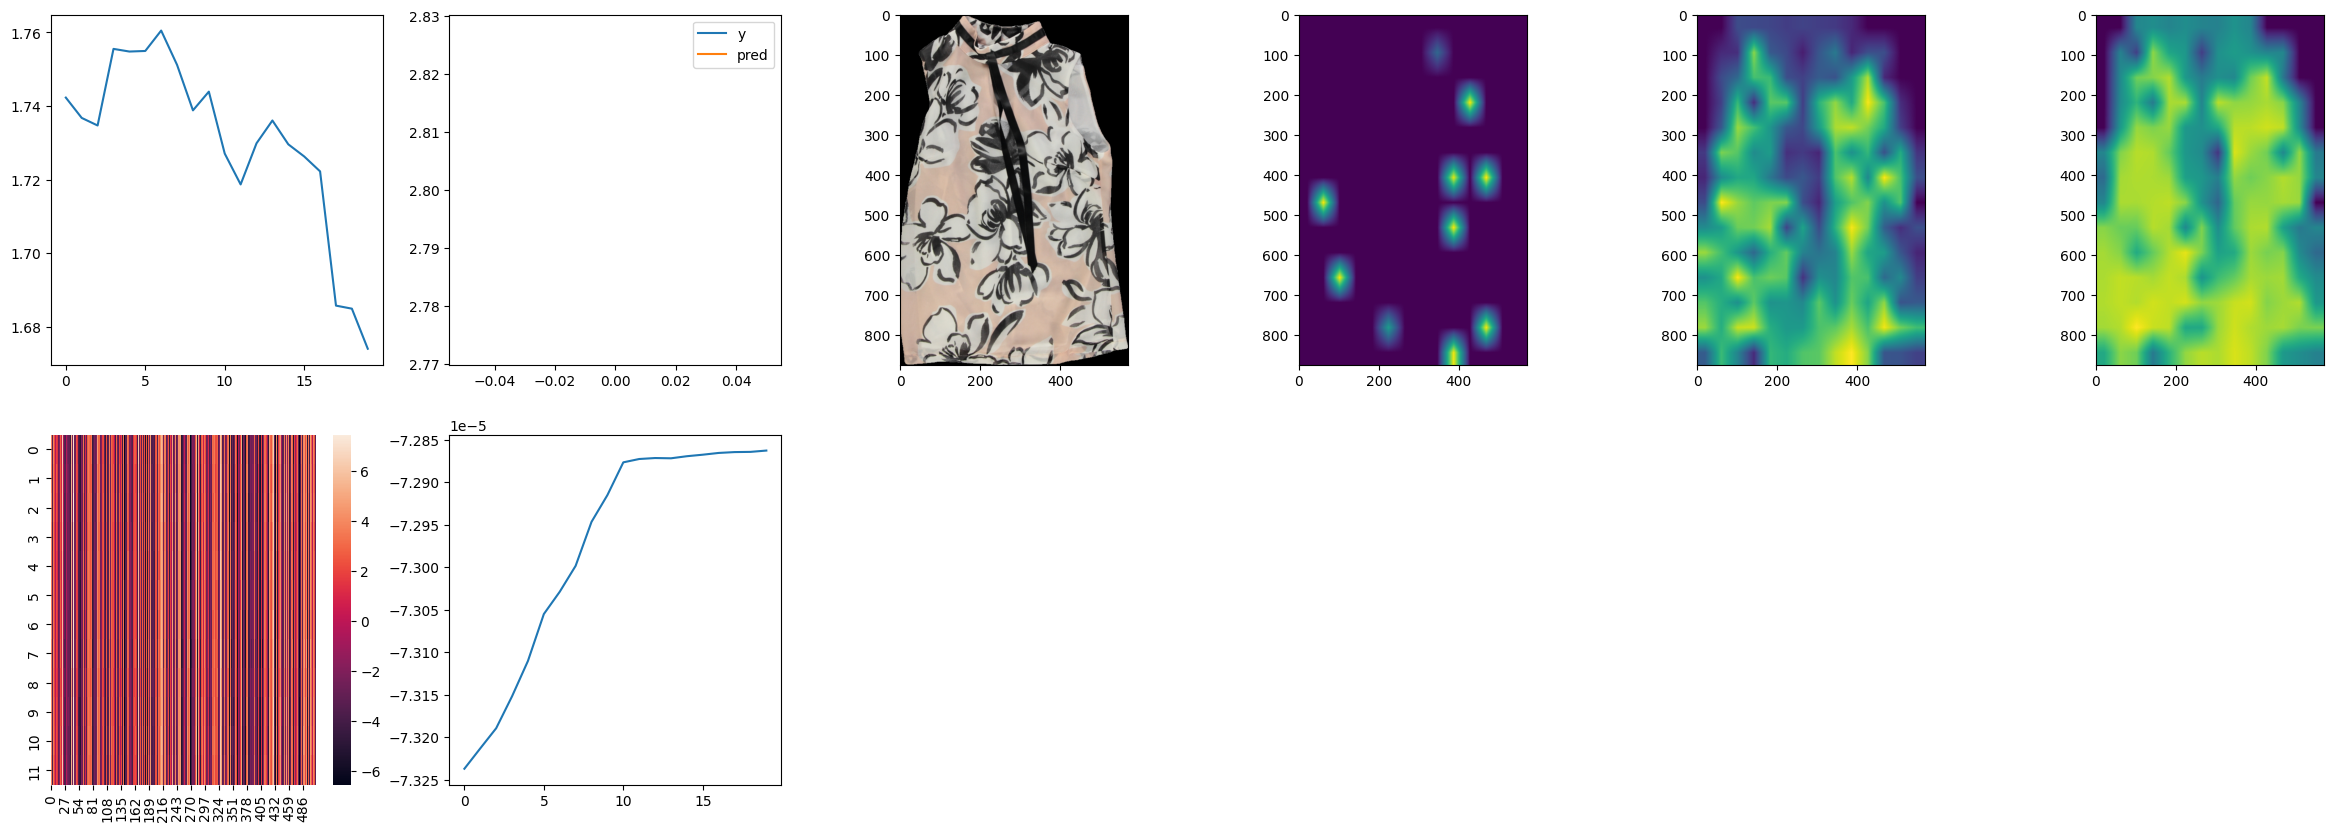

  0%|          | 0/43 [00:00<?, ?it/s]

In [10]:
patience = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", eps=1e-15, patience=patience)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
mse_loss_fn_ = torch.nn.MSELoss()

def loss_fn(pred, y):
    # mask = torch.where(y==0, 0, 1).type(torch.FloatTensor).to(device)
    loss = mse_loss_fn_(pred, y.to(device))
    # masked_loss = loss * mask
    # loss = masked_loss.sum() / mask.sum()
    return loss

def plot_sample(y, pred, loss_li, img_raw, attn_weight1, attn_weight2, attn_weight3, temporal_embedding, gradient_li):
    clear_output(wait=True)
    y_sample, pred_sample = y[-1], pred[-1].detach().cpu()

    plt.figure(figsize=(30,10))
    nrows = 2
    ncols = 6

   # Plot loss
    plt.subplot(nrows, ncols, 1)
    plt.plot(loss_li[-patience:], label="Loss")
   
   # Plot sample prediction
    plt.subplot(nrows, ncols, 2)
    plt.plot(y_sample, label="y")
    plt.plot(pred_sample, label="pred")
    plt.legend()

   # Plot img attention mask
    idx = -1
    plt.subplot(nrows, ncols, 3)
    plt.imshow(img_raw[idx])

    plt.subplot(nrows, ncols, 4)
    mask = torch.min(attn_weight3, dim=1).values
    mask = torch.mean(mask, dim=1)
    mask = mask[idx, 1:].reshape(14, 14).cpu().detach().numpy() # 28,28 or 14,14
    mask = cv2.resize(mask / mask.max(), img_raw[idx].size)[..., np.newaxis]
    plt.imshow(mask)

    plt.subplot(nrows, ncols, 5)
    mask = torch.mean(attn_weight3, dim=1)
    mask = torch.mean(mask, dim=1)
    mask = mask[idx, 1:].reshape(14, 14).cpu().detach().numpy() # 28,28 or 14,14
    mask = cv2.resize(mask / mask.max(), img_raw[idx].size)[..., np.newaxis]
    plt.imshow(mask)

    plt.subplot(nrows, ncols, 6)
    mask = torch.max(attn_weight3, dim=1).values
    mask = torch.mean(mask, dim=1)
    mask = mask[idx, 1:].reshape(14, 14).cpu().detach().numpy() # 28,28 or 14,14
    mask = cv2.resize(mask / mask.max(), img_raw[idx].size)[..., np.newaxis]
    plt.imshow(mask)

  # Plot positional encoding heatmap
    plt.subplot(nrows, ncols, 7)
    sns.heatmap(temporal_embedding[idx].detach().cpu())

  # Plot gradient
    plt.subplot(nrows, ncols, 8)
    plt.plot(gradient_li)
    
    plt.show()

def train(e):
    model.train()
    loss_li, loss_mean_li = [], []
    gradient_li = []
    pbar = tqdm(dataloader)
    patience_idx = 0

    for n, data in enumerate(pbar):
        hist, temporal, static, img_raw, img_tensor, y = data
       
       # Train
        optimizer.zero_grad()
        pred, attn_weight1, attn_weight2, attn_weight3, temporal_embedding = model(
                hist.to(device),
                temporal.to(device),
                static["input_ids"].to(device),
                static["attention_mask"].to(device),
                img_tensor.to(device),
                )
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
       # Report
        gradient_li.append(list(model.named_parameters())[-2][1].mean().detach().cpu())
        loss_li.append(loss.item())
        loss_mean_li.append(np.mean(loss_li[-patience:]))
        pbar.set_description(f'epoch{e} - loss: {np.round(np.mean(loss_mean_li[-patience:]), 5)} - lr: {optimizer.param_groups[0]["lr"]}')
        plot_sample(y, pred, loss_mean_li, img_raw, attn_weight1, attn_weight2, attn_weight3, temporal_embedding, gradient_li[-patience:])

temp = None
epoch = 20
for e in range(epoch):
    train(e)

In [ ]:
torch.save(model.state_dict(), "model_panoptic")

# Eval

In [ ]:
model.load_state_dict(torch.load("model_panoptic"))

<All keys matched successfully>

In [ ]:
model.eval()

for data in dataloader:
    hist, temporal, static, img_raw, img_tensor, y = data
    with torch.no_grad():
        pred, attn_weight1, attn_weight2, attn_weight3 = model(
                hist.to(device),
                temporal.to(device),
                static["input_ids"].to(device),
                static["token_type_ids"].to(device),
                static["attention_mask"].to(device),
                img_tensor.to(device))
        break

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_49679/235722378.py", line 412, in forward
    img_mask = torch.nn.MaxPool2d(kernel_size=16, stride=16)(img_mask)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/modules/pooling.py", line 166, in forward
    return F.max_pool2d(input, self.kernel_size, self.stride,
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/_jit_internal.py", line 484, in fn
    return if_false(*args, **kwargs)
  File "/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/nn/functional.py", line 782, in _max_pool2d
    return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
RuntimeError: non-empty 3D or 4D (batch mode) tensor expected for input


<Axes: ylabel='index'>

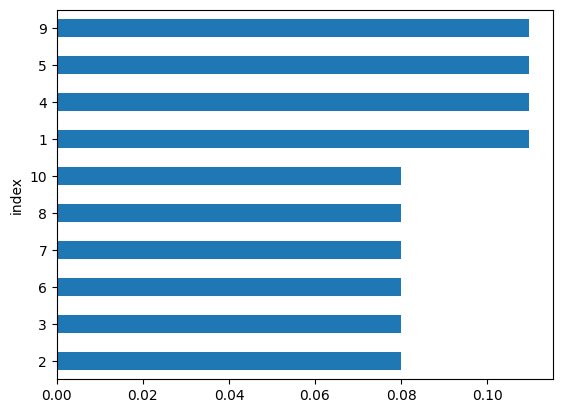

In [ ]:
import random
idx = random.randint(0, batch_size)
mask = torch.mean(attn_weight1, dim=1)
df = pd.DataFrame({"attn":mask[idx].cpu()}).sort_values("attn", ascending=True).reset_index().iloc[-10:]
df.plot.barh("index", "attn", legend=False)

<Axes: ylabel='index'>

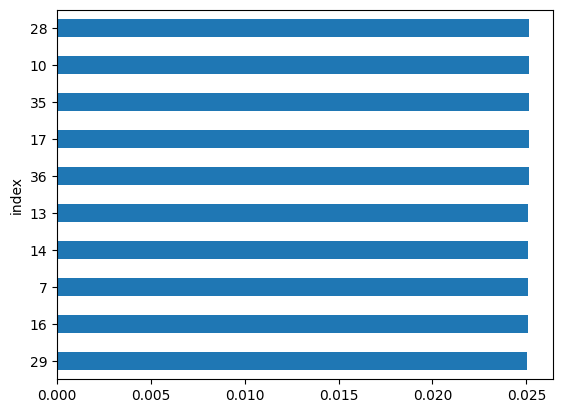

In [ ]:
import random
idx = random.randint(0, batch_size)

mask = torch.mean(attn_weight2, dim=1)
df = pd.DataFrame({"attn":mask[idx].cpu()}).sort_values("attn", ascending=True).reset_index().iloc[-10:]
df.plot.barh("index", "attn", legend=False)

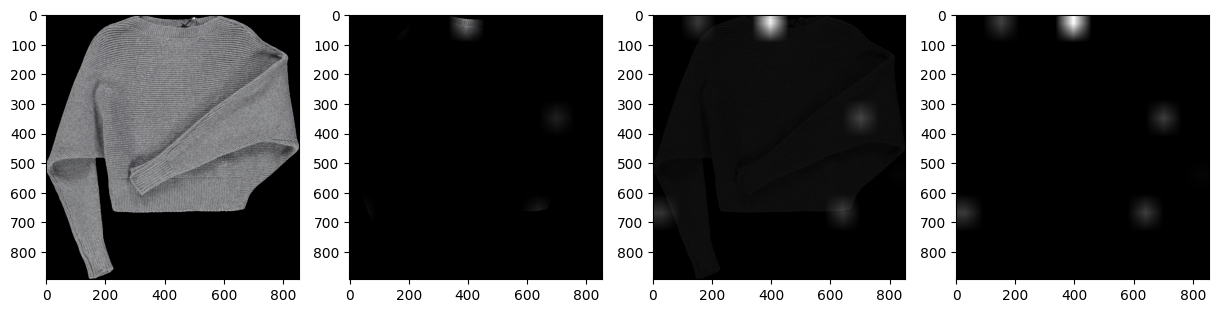

In [ ]:
import random
idx = random.randint(0, batch_size)
mask = torch.min(attn_weight3, dim=1).values
# mask = torch.mean(attn_weight3, dim=1)
mask = mask[idx, 1:].reshape(14,14).cpu().numpy()
mask = cv2.resize(mask / mask.max(), img_raw[idx].size)[..., np.newaxis]
result = (mask * img_raw[idx]).astype("uint8")

plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.imshow(img_raw[idx])

plt.subplot(1,4,2)
plt.imshow(result)

plt.subplot(1,4,3)
plt.imshow(img_raw[idx])
plt.imshow(mask, cmap="gray", alpha=0.9)

plt.subplot(1,4,4)
plt.imshow(mask, cmap="gray")
